In [1]:
% matplotlib inline

In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Parameters
nruns = 12
ndiscard = 500 # discard the first this many frames
nbins = 100
frame_interval = 0.5 # nanoseconds

In [40]:
# Load trajectories
runs = list()
for run in range(nruns):
    clones = np.load('data/run%d.npy' % run)
    for index in range(len(clones)):
        clones[index] = clones[index][ndiscard:] * 10 # convert to Angstroms and discard initial equilibration
    runs.append(clones)

In [41]:
run_index = {
    0: '1OL5-tpx2-phos',
    1: '1OL5-notpx2-phos',
    2: '1OL5-tpx2-nophos',
    3: '1OL5-tpx2-phos',
    4: '1OL7-notpx2-nophos',
    5: '1OL7-notpx2-phos',
    6: '1OL7-tpx2-nophos',
    7: '1OL7-tpx2-nophos', # accidental duplicate of 6 by Steven
    8: '5L8K-notpx2-nophos',
    9:  '5L8K-notpx2-phos',
    10: '5L8K-tpx2-nophos',
    11: '5L8K-tpx2-phos',
}

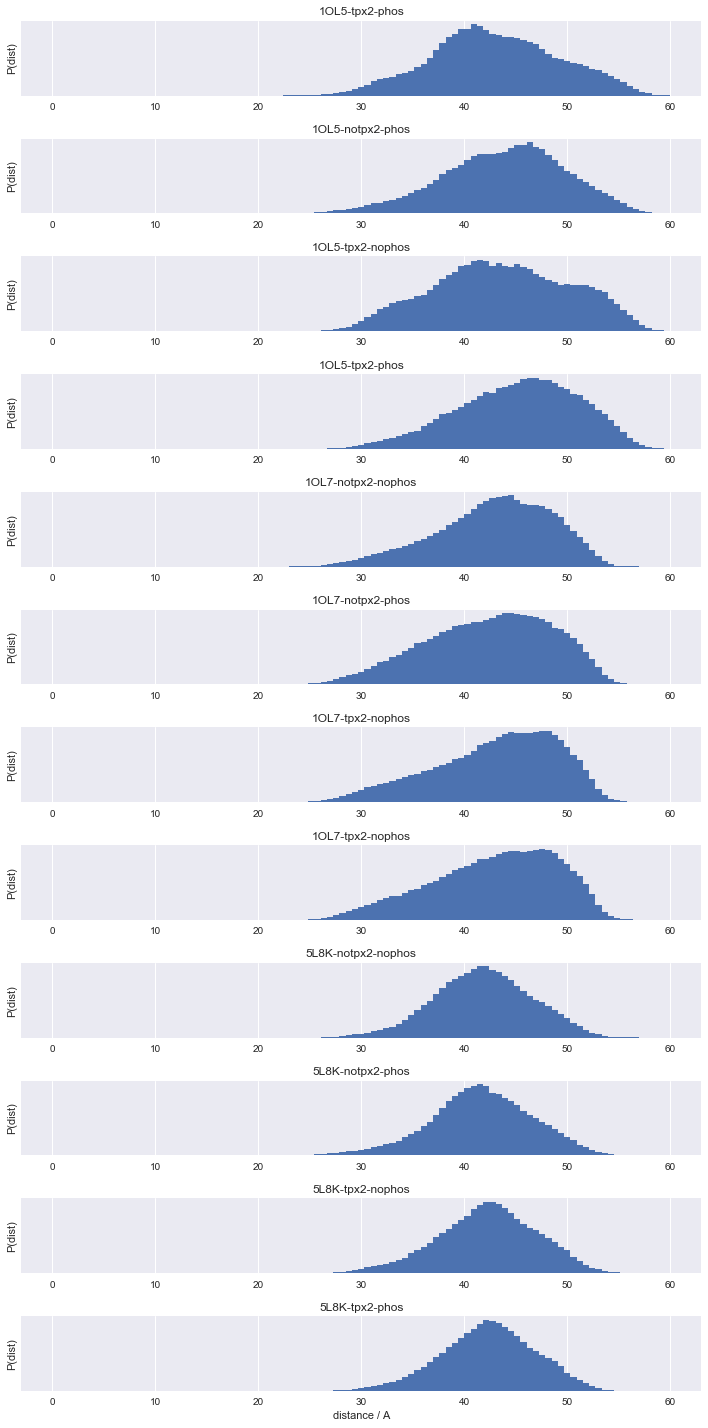

In [42]:
figure = plt.figure(figsize=[10,20])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for run in range(nruns):    
    plt.subplot(nruns,1,run+1)
    clones = runs[run]    
    plt.hist(np.concatenate(clones), bins)
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('distance / A')
    plt.ylabel('P(dist)');
    plt.title(run_index[run])

figure.tight_layout()

## How much data do we have?

In [45]:
for run in range(nruns):
    clones = runs[run]    
    concatenated = np.concatenate(clones)
    nframes = len(concatenated)
    aggregate_time = frame_interval * nframes
    print('%64s : %8.3f ns aggregate' % (run_index[run], aggregate_time))

                                                  1OL5-tpx2-phos : 68799.500 ns aggregate
                                                1OL5-notpx2-phos : 65859.500 ns aggregate
                                                1OL5-tpx2-nophos : 54250.000 ns aggregate
                                                  1OL5-tpx2-phos : 52239.500 ns aggregate
                                              1OL7-notpx2-nophos : 75660.000 ns aggregate
                                                1OL7-notpx2-phos : 76900.000 ns aggregate
                                                1OL7-tpx2-nophos : 74949.500 ns aggregate
                                                1OL7-tpx2-nophos : 76980.000 ns aggregate
                                              5L8K-notpx2-nophos : 56430.000 ns aggregate
                                                5L8K-notpx2-phos : 52950.000 ns aggregate
                                                5L8K-tpx2-nophos : 51330.000 ns aggregate
          